In [1]:
import os
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np 
import shapely 
import csv
import ast

import osm_flex.download as dl
import osm_flex.extract as ex
from osm_flex.simplify import remove_contained_points,remove_exact_duplicates,remove_contained_polys
from osm_flex.config import OSM_DATA_DIR,DICT_GEOFABRIK

from tqdm import tqdm

from lonboard import viz
from lonboard.colormap import apply_continuous_cmap
from palettable.colorbrewer.sequential import Blues_9

from pathlib import Path
import pathlib

In [2]:
#define paths
p = Path('..')
data_path = Path(pathlib.Path.home().parts[0]) / 'Projects' / 'gmhcira' / 'data' #should contain folder 'Vulnerability' with vulnerability data
flood_data_path = Path('//labsdfs.labs.vu.nl/labsdfs/BETA-IVM-BAZIS/eks510/fathom-global') # Flood data
eq_data_path = Path('//labsdfs.labs.vu.nl/data_catalogue/open_street_map/global_hazards/earthquakes/GEM')  # Earthquake data
landslide_data_path = Path('//labsdfs.labs.vu.nl/data_catalogue/open_street_map/global_hazards/landslides')  # Landslide data
cyclone_data_path = Path('//labsdfs.labs.vu.nl/data_catalogue/open_street_map/global_hazards/tropical_cyclones')  # Cyclone data

In [70]:
def country_download(iso3):
    """
    Download OpenStreetMap data for a specific country.
    Arguments:
        *iso3* (str): ISO 3166-1 alpha-3 country code.
    Returns:
        *Path*: The file path of the downloaded OpenStreetMap data file.
    """
    
    dl.get_country_geofabrik(iso3) # Use the download library to get the geofabrik data for the specified country
    data_loc = OSM_DATA_DIR.joinpath(f'{DICT_GEOFABRIK[iso3][1]}-latest.osm.pbf') # Specify the location of the OpenStreetMap (OSM) data file
    return data_loc

def overlay_hazard_assets(df_ds,assets):
    """
    Overlay hazard assets on a dataframe of spatial geometries.
    Arguments:
        *df_ds*: GeoDataFrame containing the spatial geometries of the hazard data. 
        *assets*: GeoDataFrame containing the infrastructure assets.
    Returns:
        *geopandas.GeoSeries*: A GeoSeries containing the spatial geometries of df_ds that intersect with the infrastructure assets.
    """
    
    #overlay 
    hazard_tree = shapely.STRtree(df_ds.geometry.values)
    if (shapely.get_type_id(assets.iloc[0].geometry) == 3) | (shapely.get_type_id(assets.iloc[0].geometry) == 6): # id types 3 and 6 stand for polygon and multipolygon
        return  hazard_tree.query(assets.geometry,predicate='intersects')    
    else:
        return  hazard_tree.query(assets.buffered,predicate='intersects')

def buffer_assets(assets,buffer_size=0.00083):
    """
    Buffer spatial assets in a GeoDataFrame.
    Arguments:
        *assets*: GeoDataFrame containing spatial geometries to be buffered.
        *buffer_size* (float, optional): The distance by which to buffer the geometries. Default is 0.00083.
    Returns:
        *GeoDataFrame*: A new GeoDataFrame with an additional 'buffered' column containing the buffered geometries.
    """
    assets['buffered'] = shapely.buffer(assets.geometry.values,distance=buffer_size)
    return assets

def get_damage_per_asset(asset,hazard_numpified,asset_geom,hazard_intensity,fragility_values,maxdam_asset):
    """
    Calculate damage for a given asset based on hazard information.
    Arguments:
        *asset*: Tuple containing information about the asset. It includes:
            - Index or identifier of the asset (asset[0]).
            - The specific hazard points in which asset is exposed (asset[1]['hazard_point']).
        *hazard_numpified*: NumPy array representing hazard information.
        *asset_geom*: Shapely geometry representing the spatial coordinates of the asset.
        *hazard_intensity*: NumPy array representing the hazard intensities of the curve for the asset type.
        *fragility_values*: NumPy array representing the damage factors of the curve for the asset type.
        *maxdam_asset*: Maximum damage value for asset.
    Returns:
        *float*: The calculated damage for the specific asset.
    """
     
    # find the exact hazard overlays:
    get_hazard_points = hazard_numpified[asset[1]['hazard_point'].values] 
    get_hazard_points[shapely.intersects(get_hazard_points[:,1],asset_geom)]

    # estimate damage
    if len(get_hazard_points) == 0: # no overlay of asset with hazard
        return 0
    
    else:
        if asset_geom.geom_type == 'LineString':
            overlay_meters = shapely.length(shapely.intersection(get_hazard_points[:,1],asset_geom)) # get the length of exposed meters per hazard cell
            return np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*overlay_meters*maxdam_asset) #return asset number, total damage for asset number (damage factor * meters * max. damage)
        elif asset_geom.geom_type in ['MultiPolygon','Polygon']:
            overlay_m2 = shapely.area(shapely.intersection(get_hazard_points[:,1],asset_geom))
            return np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*overlay_m2*maxdam_asset) #return asset number, total damage for asset number (damage factor * meters * max. damage)
        elif asset_geom.geom_type == 'Point':
            return np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*maxdam_asset)

def create_pathway_dict(data_path, flood_data_path, eq_data_path, landslide_data_path, cyclone_data_path): 

    """
    Create a dictionary containing paths to various hazard datasets.
    Arguments:
        *data_path* (Path): Base directory path for general data.
        *flood_data_path* (Path): Path to flood hazard data.
        *eq_data_path* (Path): Path to earthquake hazard data.
        *landslide_data_path* (Path): Path to landslide hazard data.
        *cyclone_data_path* (Path): Path to tropical cyclone hazard data.
    Returns:
        *dict*: A dictionary where keys represent a general pathway and different hazard types and values are corresponding paths.
    """

    #create a dictionary
    pathway_dict = {'data_path': data_path, 
                    'fluvial': flood_data_path, 
                    'pluvial': flood_data_path, 
                    'windstorm': cyclone_data_path, 
                    'earthquake': eq_data_path, 
                    'landslides': landslide_data_path,}

    return pathway_dict

def read_hazard_data(hazard_data_path,hazard_type):
    """
    Read hazard data files for a specific hazard type.
    Arguments:
        *hazard_data_path* (Path): Base directory path where hazard data is stored.
        *hazard_type* (str): Type of hazard for which data needs to be read ('fluvial', 'pluvial', 'windstorm', 'earthquake', 'landslides').
    
    Returns:
        *list*: A list of Path objects representing individual hazard data files for the specified hazard type.
    """  

    if hazard_type == 'fluvial':
        hazard_data = hazard_data_path / 'Jamaica' / 'fluvial_undefended' # need to make country an input
        return list(hazard_data.iterdir())

    elif hazard_type == 'pluvial':
        hazard_data = hazard_data_path / 'Jamaica' / 'pluvial' # need to make country an input
        return list(hazard_data.iterdir())

    elif hazard_type == 'windstorm':
        hazard_data = hazard_data_path 
        return list(hazard_data.iterdir())

    elif hazard_type == 'earthquake':
        hazard_data = hazard_data_path
        return list(hazard_data.iterdir())

    elif hazard_type == 'landslides':
        hazard_data = hazard_data_path 
        return list(hazard_data.iterdir())


def read_vul_maxdam(data_path,hazard_type,infra_type):
    """
    Read vulnerability curves and maximum damage data for a specific hazard and infrastructure type.
    Arguments:
        *data_path*: The base directory path where vulnerability and maximum damage data files are stored.
        *hazard_type*: The type of hazard in string format, such as 'pluvial', 'fluvial', or 'windstorm'.
        *infra_type*: The type of infrastructure in string format for which vulnerability curves and maximum damage data are needed.
    
    Returns:
        *tuple*: A tuple containing two DataFrames:
            - The first DataFrame contains vulnerability curves specific to the given hazard and infrastructure type.
            - The second DataFrame contains maximum damage data for the specified infrastructure type.
    """

    vul_data = data_path / 'Vulnerability'
    
    # Load assumptions file containing curve - maxdam combinations per infrastructure type
    assumptions = pd.read_excel(vul_data / 'S1_Assumptions_Test.xlsx',sheet_name = 'Flooding assumptions',header=[1])
    assumptions['Infrastructure type'] = assumptions['Infrastructure type'].str.lower()
    assump_infra_type = assumptions[assumptions['Infrastructure type'] == infra_type]
    assump_curves = ast.literal_eval(assump_infra_type['Vulnerability ID number'].item())
    assump_maxdams = ast.literal_eval(assump_infra_type['Maximum damage ID number'].item())
    
    # Get curves
    if hazard_type in ['pluvial','fluvial']:  
        curves = pd.read_excel(vul_data / 'Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx',sheet_name = 'F_Vuln_Depth',index_col=[0],header=[0,1,2,3,4])
    elif hazard_type == 'windstorm':
        curves = pd.read_excel(vul_data / 'Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx',sheet_name = 'W_Vuln_V10m',index_col=[0],header=[0,1,2,3,4])
    
    infra_curves =  curves[assump_curves]
    
    # get maxdam
    maxdam = pd.read_excel(vul_data / 'Table_D3_Costs_V1.0.1.xlsx', sheet_name='Cost_Database',index_col=[0])
    infra_maxdam = maxdam[maxdam.index.isin(assump_maxdams)]['Amount'].dropna()
    infra_maxdam = infra_maxdam[pd.to_numeric(infra_maxdam, errors='coerce').notnull()]

    return infra_curves,infra_maxdam

def read_flood_map(flood_map_path,diameter_distance=0.00083/2):
    """
    Read flood map data from a NetCDF file and process it into a GeoDataFrame.
    Arguments:
        *flood_map_path* (Path): Path to the NetCDF file containing flood map data.
        *diameter_distance* (float, optional): The diameter distance used for creating square geometries around data points. Default is 0.00083/2.
    
    Returns:
        *geopandas.GeoDataFrame*: A GeoDataFrame representing the processed flood map data.
    """
    
    flood_map = xr.open_dataset(flood_map_path, engine="rasterio")

    flood_map_vector = flood_map['band_data'].to_dataframe().reset_index() #transform to dataframe
    
    #remove data that will not be used
    flood_map_vector = flood_map_vector.loc[(flood_map_vector.band_data > 0) & (flood_map_vector.band_data < 100)]
    
    # create geometry values and drop lat lon columns
    flood_map_vector['geometry'] = [shapely.points(x) for x in list(zip(flood_map_vector['x'],flood_map_vector['y']))]
    flood_map_vector = flood_map_vector.drop(['x','y','band','spatial_ref'],axis=1)
    
    # drop all non values to reduce size
    flood_map_vector = flood_map_vector.loc[~flood_map_vector['band_data'].isna()].reset_index(drop=True)
    
    # and turn them into squares again:
    flood_map_vector.geometry= shapely.buffer(flood_map_vector.geometry,distance=diameter_distance,cap_style='square').values 

    return flood_map_vector

def read_windstorm_map(windstorm_map_path,bbox):
     
    # load data from NetCDF file
    with xr.open_dataset(flood_map_path) as ds:
        
        # convert data to WGS84 CRS
        ds.rio.write_crs(4326, inplace=True)
        ds = ds.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
        #ds['band_data'] = ds['band_data']/0.88*1.11 #convert 10-min sustained wind speed to 3-s gust wind speed
    
        ds_vector = ds['band_data'].to_dataframe().reset_index() #transform to dataframe
        
        #remove data that will not be used
        ds_vector = ds_vector.loc[(ds_vector.band_data > 0) & (ds_vector.band_data < 100)]
        
        # create geometry values and drop lat lon columns
        ds_vector['geometry'] = [shapely.points(x) for x in list(zip(ds_vector['x'],ds_vector['y']))]
        ds_vector = ds_vector.drop(['x','y','band','spatial_ref'],axis=1)
        ds_vector['geometry'] = shapely.buffer(ds_vector.geometry, distance=0.1/2, cap_style='square').values
    
        return ds_vector

def combine_columns(a, b):
    """
    Combine values from two input arguments 'a' and 'b' into a single string.
    Arguments:
    - a (str or None): Value from column 'A'.
    - b (str or None): Value from column 'B'.

    Returns:
    - str or None: A string of 'a', 'b' or combination. If both 'a' and 'b' are None, return None.
    """
    
    if pd.notna(a) and pd.notna(b) == False: #if only a contains a string
        return f"{a}" 
    elif pd.notna(b) and pd.notna(a) == False: #if only b contains a string
        return f"{b}"
    elif pd.notna(a) and pd.notna(b):  #if both values contain a string
        if a == b: 
            return f"{a}"
        elif a == 'yes' or b == 'yes':
            if a == 'yes':
                return  f"{b}"
            elif b == 'yes':
                return  f"{a}"
        else: 
            return f"{a}" #f"{a}_{b}" # assuming that value from column A contains the more detailed information
    else: 
        None # Decision point: If nones are existent, decide on what to do with Nones. Are we sure that these are education facilities? Delete them? Provide another tag to them?

def filter_dataframe(assets, column_names_lst):
    """
    Filter a GeoDataFrame by combining information from two specified columns and removing selected columns.
    Args:
        assets (geopandas.GeoDataFrame): The input GeoDataFrame containing spatial geometries and columns to filter.
        column_names_lst (list): A list of two column names whose information needs to be combined to create a new 'asset' column.

    Returns:
        geopandas.GeoDataFrame: A filtered GeoDataFrame with a new 'asset' column and selected columns dropped, and points converted to polygons.
    """

    if len(column_names_lst) == 2:        
        assets['asset'] = assets.apply(lambda row: combine_columns(row[column_names_lst[0]], row[column_names_lst[1]]), axis=1) # create new column based on tag information provided in two columns
    elif len(column_names_lst) == 3:
        assets['asset_temp'] = assets.apply(lambda row: combine_columns(row[column_names_lst[0]], row[column_names_lst[1]]), axis=1) # create temp column based on tag information provided in two columns
        assets['asset'] = assets.apply(lambda row: combine_columns(row['asset_temp'], row[column_names_lst[2]]), axis=1) # create new column based on tag information provided in two columns
        column_names_lst.append('asset_temp')        
    else:
        print("Warning: column_names_lst should contain 2 or 3 items")

    assets = assets.drop(columns=column_names_lst, axis=1) # drop columns
    assets =  process_asset_geometry(assets)
    
    return assets


def process_asset_geometry(assets):
    """
    Process the geometry of assets, removing contained points and polygons, and converting points to polygons.
    Args:
        assets (geopandas.GeoDataFrame): Input GeoDataFrame containing asset geometries.

    Returns:
        geopandas.GeoDataFrame: Processed GeoDataFrame with updated asset geometries.
    """
    
    assets =  remove_contained_polys(remove_contained_points(assets))
    
    #convert points to polygons
    assets.loc[assets.geom_type == 'Point','geometry'] = assets.loc[assets.geom_type == 'Point'].buffer(
                                                                    distance=np.sqrt(assets.loc[assets.geom_type == 'MultiPolygon'].area.median())/2, cap_style='square')

    return assets


def delete_linestring_data(assets, infra_lst):
    """
    Filter and update a GeoDataFrame by excluding rows with LineString geometries.

    Parameters:
    - assets (geopandas.GeoDataFrame): The original GeoDataFrame.
    - infra_lst (lst): A list with the infrastructure typs to filter.

    Returns:
    - geopandas.GeoDataFrame: The updated GeoDataFrame with excluded LineString rows.
    """

    for infra_type in infra_lst:
        #create subset of data
        condition = assets['asset'] == infra_type
        subset = assets[condition]
        
        #delete line data if there is line data (assuming that this function is only for point and polygon data)
        subset = subset.drop(subset[subset['geometry'].geom_type == 'LineString'].index) #drop linestrings
    
        #update the original Dataframe by excluding rows in the subset
        assets = assets[~condition | condition & subset['geometry'].notna()]

    return assets
    

def create_damage_csv(damage_output, hazard_type, pathway_dict, country_code, sub_system):
    """
    Create a CSV file containing damage information.
    Arguments:
        damage_output: A dictionary containing damage information.
        hazard_type: The type of hazard (e.g., 'earthquake', 'flood').
        pathway_dict: A dictionary containing file paths for different data.
        country_code: A string containing information about the country code
        sub_system: A string containing information about the subsystem considered

    Returns:
        None
    """
  
    hazard_output_path = pathway_dict['data_path'] / 'damage' / country_code
    
    # Check if the directory exists
    if not hazard_output_path.exists():
        # Create the directory
        hazard_output_path.mkdir(parents=True, exist_ok=True)
    
    csv_file_path = hazard_output_path / '{}_{}_{}.csv'.format(country_code, hazard_type, sub_system)
    
    with open(csv_file_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        
        # Write header
        csv_writer.writerow(['Country', 'Return period', 'Subsystem', 'Infrastructure type', 'Curve ID number', 'Damage ID number', 'Damage'])
        
        # Write data
        for key, value in damage_output.items():
            csv_writer.writerow(list(key) + [value])
    
    print(f"CSV file created at: {csv_file_path}")

In [67]:
def country_infrastructure_hazard(pathway_dict, country_code, sub_system, infra_type_lst, hazard_type):

    # get country osm data
    data_loc = country_download(country_code)
    
    # get infrastructure data:
    print(f'Time to extract OSM data for {sub_system}')
    assets = ex.extract_cis(data_loc, sub_system)
    
    # convert assets to epsg3857 (system in meters)
    assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
    
    if sub_system == 'road':
        assets = assets.loc[assets.geometry.geom_type == 'LineString']
        assets = assets.rename(columns={'highway' : 'asset'})
        list_of_highway_assets_to_keep =["motorway", "motorway_link", "motorway_junction", "trunk", "trunk_link",
            "primary", "primary_link", "secondary", "secondary_link", "tertiary", "tertiary_link", "residential",           
            "road", "unclassified", "living_street", "pedestrian", "bus_guideway", "escape", "raceway", 
            "cycleway", "construction", "bus_stop", "crossing", "mini_roundabout", "passing_place", "rest_area", "turning_circle", 
            "traffic_island", "yes", "emergency_bay", "service"]
        
        #reclassify assets 
        mapping_dict = {
            "motorway" : "motorway", 
            "motorway_link" : "motorway", 
            "motorway_junction" : "motorway",
            "trunk" : "trunk",
            "trunk_link" : "trunk",
            "primary" : "primary", 
            "primary_link" : "primary", 
            "secondary" : "secondary", 
            "secondary_link" : "secondary", 
            "tertiary" : "tertiary", 
            "tertiary_link" : "tertiary", 
            "residential" : "other",           
            "road" : "other", 
            "unclassified" : "other",
            "living_street" : "other", 
            "pedestrian" : "other", 
            "bus_guideway" : "other", 
            "escape" : "other", 
            "raceway" : "other", 
            "cycleway" : "other", 
            "construction" : "other", 
            "bus_stop" : "other", 
            "crossing" : "other", 
            "mini_roundabout" : "other", 
            "passing_place" : "other", 
            "rest_area" : "other", 
            "turning_circle" : "other",
            "traffic_island" : "other",
            "yes" : "other",
            "emergency_bay" : "other",
            "service" : "other"
        }
        assets['asset'] = assets.asset.apply(lambda x : mapping_dict[x])  #reclassification
    
    elif sub_system == 'power':
        assets = assets.rename(columns={'power' : 'asset'}).reset_index(drop=True)
        infra_lst = ['plant', 'substation']
        assets = delete_linestring_data(assets, infra_lst) #check for linestring data for specific infrastructure types and delete
    
    elif sub_system == 'rail':
        assets = assets.loc[assets.geometry.geom_type == 'LineString']
        assets = assets.rename(columns={'railway' : 'asset'})
    
    elif sub_system == 'air':
        assets = assets.rename(columns={'aeroway' : 'asset'})   

    elif sub_system == 'telecom':
        assets = assets[assets['tower_type'] == 'communication'] #filter towers that are used for communnication purposes only
        assets = assets.drop(['tower_type', 'communication_mobile_phone'], axis=1).reset_index(drop=True) #drop columns that are of no further use
        assets = assets.drop(assets[assets['geometry'].geom_type == 'LineString'].index).reset_index(drop=True) #drop linestrings
        column_names_lst = ['man_made' , 'telecom']
        assets_test = filter_dataframe(assets, column_names_lst)

    elif sub_system == 'water':
        assets = assets.reset_index(drop=True)
        assets = assets.drop(assets[assets['emergency'] == 'fire_hydrant'].index).reset_index(drop=True) #drop linestrings
        assets = assets.rename(columns={'man_made' : 'asset'})   
    
    elif sub_system == 'wastewater':
        assets = assets.rename(columns={'man_made' : 'asset'}) 
        assets = process_asset_geometry(assets)
    
    elif sub_system == 'education':
        column_names_lst = ['amenity' , 'building']
        assets = filter_dataframe(assets, column_names_lst)

    elif sub_system == 'healthcare':
        column_names_lst = ['amenity' , 'building', 'healthcare']
        assets = filter_dataframe(assets, column_names_lst)
    
    # read hazard data
    hazard_data_path = pathway_dict[hazard_type]
    hazard_data_list = read_hazard_data(hazard_data_path,hazard_type)

    # start analysis 
    print(f'{country_code} runs for {sub_system} for {hazard_type} for {len(hazard_data_list)} maps')

    if hazard_type in ['windstorm','earthquake','landslide']:
        # load country geometry file and create geometry to clip
        ne_countries = gpd.read_file(data_path / "natural_earth" / "ne_10m_admin_0_countries.shp") #https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
        bbox = ne_countries.loc[ne_countries['ISO_A3']==country_code].geometry.envelope.values[0].bounds
        
    collect_output = {}
    for single_footprint in hazard_data_list: #tqdm(hazard_data_list,total=len(hazard_data_list)):
    
        hazard_name = single_footprint.parts[-1].split('.')[0]
        
        # load hazard map
        if hazard_type in ['pluvial','fluvial']:
            hazard_map = read_flood_map(single_footprint)
        elif hazard_type in ['windstorm']:
             hazard_map = read_windstorm_map(single_footprint,bbox)
        elif hazard_type in ['earthquake']:
             hazard_map = read_earthquake_map(single_footprint)
        elif hazard_type in ['landslide']:
             hazard_map = read_landslide_map(single_footprint)
         
        # convert hazard data to epsg 3857
        hazard_map = gpd.GeoDataFrame(hazard_map).set_crs(4326).to_crs(3857)

        # Loop through unique infrastructure types within the subsystem
        for infra_type in infra_type_lst: 
            assets_infra_type = assets[assets['asset'] == infra_type].copy().reset_index(drop=True)
        
            # create dicts for quicker lookup
            geom_dict = assets_infra_type['geometry'].to_dict()
            type_dict = assets_infra_type['asset'].to_dict()

            # read vulnerability and maxdam data:
            data_path = pathway_dict['data_path']
            infra_curves,maxdams = read_vul_maxdam(data_path,hazard_type, infra_type)

            # start analysis 
            print(f'{country_code} runs for {infra_type} for {hazard_type} for {hazard_name} map for {len(infra_curves.T)*len(maxdams)} combinations')
    
            # overlay assets
            overlay_assets = pd.DataFrame(overlay_hazard_assets(hazard_map,buffer_assets(assets_infra_type)).T,columns=['asset','hazard_point'])
    
            # convert dataframe to numpy array
            hazard_numpified = hazard_map.to_numpy() 

            for infra_curve in infra_curves:
                # get curves
                curve = infra_curves[infra_curve[0]]
                hazard_intensity = curve.index.values
                fragility_values = (np.nan_to_num(curve.values,nan=(np.nanmax(curve.values)))).flatten()
                        
                for maxdam in maxdams:
                    
                    collect_inb = []
                    for asset in tqdm(overlay_assets.groupby('asset'),total=len(overlay_assets.asset.unique())): #group asset items for different hazard points per asset and get total number of unique assets
                        if np.max(fragility_values) == 0: #if exposure does not lead to damage
                            collect_inb.append(0)  
                        else:
                            asset_geom = geom_dict[asset[0]]
                            collect_inb.append(get_damage_per_asset(asset,hazard_numpified,asset_geom,hazard_intensity,fragility_values,maxdam)) #get list of damages for specific asset
                    collect_output[country_code, hazard_name, sub_system, infra_type, infra_curve[0], maxdam] = np.sum(collect_inb) # dictionary to store results for various combinations of hazard maps, infrastructure curves, and maximum damage values.
        break #delete after testing
    return collect_output


            

In [74]:
def country_infrastructure_hazard(pathway_dict, country_code, sub_system, infra_type_lst, hazard_type):

    # get country osm data
    data_loc = country_download(country_code)
    
    # get infrastructure data:
    print(f'Time to extract OSM data for {sub_system}')
    assets = ex.extract_cis(data_loc, sub_system)
    
    # convert assets to epsg3857 (system in meters)
    assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
    
    if sub_system == 'road':
        assets = assets.loc[assets.geometry.geom_type == 'LineString']
        assets = assets.rename(columns={'highway' : 'asset'})
        list_of_highway_assets_to_keep =["motorway", "motorway_link", "motorway_junction", "trunk", "trunk_link",
            "primary", "primary_link", "secondary", "secondary_link", "tertiary", "tertiary_link", "residential",           
            "road", "unclassified", "living_street", "pedestrian", "bus_guideway", "escape", "raceway", 
            "cycleway", "construction", "bus_stop", "crossing", "mini_roundabout", "passing_place", "rest_area", "turning_circle", 
            "traffic_island", "yes", "emergency_bay", "service"]
        
        #reclassify assets 
        mapping_dict = {
            "motorway" : "motorway", 
            "motorway_link" : "motorway", 
            "motorway_junction" : "motorway",
            "trunk" : "trunk",
            "trunk_link" : "trunk",
            "primary" : "primary", 
            "primary_link" : "primary", 
            "secondary" : "secondary", 
            "secondary_link" : "secondary", 
            "tertiary" : "tertiary", 
            "tertiary_link" : "tertiary", 
            "residential" : "other",           
            "road" : "other", 
            "unclassified" : "other",
            "living_street" : "other", 
            "pedestrian" : "other", 
            "bus_guideway" : "other", 
            "escape" : "other", 
            "raceway" : "other", 
            "cycleway" : "other", 
            "construction" : "other", 
            "bus_stop" : "other", 
            "crossing" : "other", 
            "mini_roundabout" : "other", 
            "passing_place" : "other", 
            "rest_area" : "other", 
            "turning_circle" : "other",
            "traffic_island" : "other",
            "yes" : "other",
            "emergency_bay" : "other",
            "service" : "other"
        }
        assets['asset'] = assets.asset.apply(lambda x : mapping_dict[x])  #reclassification
    
    elif sub_system == 'power':
        assets = assets.rename(columns={'power' : 'asset'}).reset_index(drop=True)
        infra_lst = ['plant', 'substation']
        assets = delete_linestring_data(assets, infra_lst) #check for linestring data for specific infrastructure types and delete
    
    elif sub_system == 'rail':
        assets = assets.loc[assets.geometry.geom_type == 'LineString']
        assets = assets.rename(columns={'railway' : 'asset'})
    
    elif sub_system == 'air':
        assets = assets.rename(columns={'aeroway' : 'asset'})   

    elif sub_system == 'telecom':
        assets = assets[assets['tower_type'] == 'communication'] #filter towers that are used for communnication purposes only
        assets = assets.drop(['tower_type', 'communication_mobile_phone'], axis=1).reset_index(drop=True) #drop columns that are of no further use
        assets = assets.drop(assets[assets['geometry'].geom_type == 'LineString'].index).reset_index(drop=True) #drop linestrings
        column_names_lst = ['man_made' , 'telecom']
        assets_test = filter_dataframe(assets, column_names_lst)

    elif sub_system == 'water':
        assets = assets.reset_index(drop=True)
        assets = assets.drop(assets[assets['emergency'] == 'fire_hydrant'].index).reset_index(drop=True) #drop linestrings
        assets = assets.rename(columns={'man_made' : 'asset'})   
    
    elif sub_system == 'wastewater':
        assets = assets.rename(columns={'man_made' : 'asset'}) 
        assets = process_asset_geometry(assets)
    
    elif sub_system == 'education':
        column_names_lst = ['amenity' , 'building']
        assets = filter_dataframe(assets, column_names_lst)

    elif sub_system == 'healthcare':
        column_names_lst = ['amenity' , 'building', 'healthcare']
        assets = filter_dataframe(assets, column_names_lst)

    print(assets)

In [75]:
# List of critical infrastructure systems to process
cis_dict = {
    "energy": {"power": ["line","minor_line","cable","plant","substation",
                        "power_tower","power_pole"]},
    "transportation": {"road":  ["primary", "secondary", "tertiary"], 
                        "air": ["airports"],
                        "rail": ["rail"]},
    "water_supply": {"water": ["water_tower", "water_well", "reservoir_covered",
                                "water_works", "reservoir"]},
    "waste_solid": {"wastewater": ["landfill","waste_transfer_station"],
            "wastewater": ["wastewater_plant"]},
    "telecommunication": {"telecom": ["communication_tower", "mast"]},
    "healthcare": {"healthcare": ["clinic", "doctors", "hospital", "dentist", "pharmacy", 
                        "physiotherapist", "alternative", "laboratory", "optometrist", "rehabilitation", 
                        "blood_donation", "birthing_center"]},
    "education": {"education": ["college", "kindergarten", "library", "school", "university"]}
}

#cis_dict = {
#    "healthcare": {"healthcare": ["clinic", "doctors", "hospital", "dentist", "pharmacy", 
#                        "physiotherapist", "alternative", "laboratory", "optometrist", "rehabilitation", 
#                        "blood_donation", "birthing_center"]}
#                      }

In [8]:
hazard_type='pluvial'
country_codes=['JAM']

# Run analysis

In [76]:
pathway_dict = create_pathway_dict(data_path, flood_data_path, eq_data_path, landslide_data_path, cyclone_data_path)
for country_code in country_codes: 
    for ci_system in cis_dict: 
        for sub_system in cis_dict[ci_system]:
            infra_type_lst = cis_dict[ci_system][sub_system]
            test = country_infrastructure_hazard(pathway_dict, country_code, sub_system, infra_type_lst, hazard_type)
            #create_damage_csv(test, hazard_type, pathway_dict, country_code, sub_system)

Time to extract OSM data for power


extract lines: 100%|███████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  8.33it/s]


          osm_id  asset voltage utility      name  \
0     2064023633  tower    None    None      None   
1     2064023644  tower    None    None      None   
2     2064023658  tower    None    None      None   
3     2064023676   pole    None    None      None   
4     2064023678   pole    None    None      None   
...          ...    ...     ...     ...       ...   
2280  1156837645   line    None    None      None   
2281  1156837646   line    None    None      None   
2282  1156837647   line    None    None      None   
2283  1156837648   line  138000    None      None   
2284  1156837649   line  138000    None  2x 138kV   

                                               geometry  
0                      POINT (-8633081.076 2038005.810)  
1                      POINT (-8633297.504 2038051.109)  
2                      POINT (-8632579.649 2038085.557)  
3                      POINT (-8633546.169 2038243.963)  
4                      POINT (-8633702.618 2038249.535)  
...            

extract points: 0it [00:00, ?it/s]
extract lines: 100%|███████████████████████████████████████████████████████████| 39974/39974 [00:10<00:00, 3857.77it/s]


           osm_id      asset                name maxspeed lanes  surface  \
0        22882710   tertiary        North Parade       50     2  asphalt   
1        22882712  secondary         East Avenue       50     2  asphalt   
2        22882734   tertiary        Kings Avenue     None  None  asphalt   
3        22882736   tertiary       Orange Street       50  None  asphalt   
4        22882743   tertiary  Collie Smith Drive       50  None  asphalt   
...           ...        ...                 ...      ...   ...      ...   
39969  1228070188   tertiary      Concordia Road     None  None     None   
39970  1228070189   tertiary                None     None  None     None   
39971  1228078479   tertiary                None     None  None     None   
39972  1228078480   tertiary                None     None  None     None   
39973  1228087141   tertiary                None     None  None     None   

                                                geometry  
0      LINESTRING (-8548643.

extract multipolygons: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


  osm_id      asset                                 name  \
0   None  aerodrome  Norman Manley International Airport   
1   None  aerodrome                 Tinson Pen Aerodrome   
2   None  aerodrome    Ian Fleming International Airport   
3   None  aerodrome                    Kirkvine Airstrip   
4   None  aerodrome                  Ken Jones Aerodrome   
5   None  aerodrome       Sangster International Airport   

                                            geometry  
0  MULTIPOLYGON (((-8547261.029 2030407.987, -854...  
1  MULTIPOLYGON (((-8551459.667 2035696.386, -855...  
2  MULTIPOLYGON (((-8569039.530 2084896.931, -856...  
3  MULTIPOLYGON (((-8624697.884 2046379.525, -862...  
4  MULTIPOLYGON (((-8519316.754 2060753.030, -851...  
5  MULTIPOLYGON (((-8674506.554 2096294.878, -867...  
Time to extract OSM data for rail


extract lines: 100%|███████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.84it/s]


        osm_id asset                                    name gauge  \
0     25878434  rail                                    None  1435   
1     49406367  rail                                    None  1435   
2     49483414  rail                                    None  None   
3     49483419  rail                                    None  1435   
4     49483421  rail                                    None  1435   
5     49483422  rail                                    None  1435   
6     49483423  rail                                    None  1435   
7     49483424  rail                                    None  None   
8     49483428  rail                                    None  1435   
9     49742782  rail                                    None  1435   
10    49742783  rail                                    None  1435   
11    49834583  rail                                    None  1435   
12    79971945  rail   JRC Mainline (Kingston - Montego Bay)  1435   
13    79972014  rail

extract lines: 100%|███████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.30it/s]


        osm_id              asset     pump pipeline emergency  \
0   3662161311        water_tower     None     None      None   
1   3940147620         water_well     None     None      None   
2   4112030630        water_works     None     None      None   
3   4142137691        water_works     None     None      None   
4   4142255091       storage_tank     None     None      None   
5   4173884084        water_works     None     None      None   
6   9821319499         water_well  powered     None      None   
7   9821319512         water_well     None     None      None   
8         None               None     None     None      None   
9         None               None     None     None      None   
10        None               None     None     None      None   
11        None               None     None     None      None   
12        None               None     None     None      None   
13        None               None     None     None      None   
14        None           

extract multipolygons: 100%|███████████████████████████████████████████████████████████| 23/23 [00:35<00:00,  1.54s/it]
extract lines: 0it [00:04, ?it/s]


        osm_id reservoir_type             asset utility natural  \
0   5154145268           None  wastewater_plant    None    None   
1   5158038559           None  wastewater_plant    None    None   
2         None           None  wastewater_plant    None    None   
3         None           None  wastewater_plant    None    None   
4         None           None  wastewater_plant    None    None   
5         None           None  wastewater_plant    None    None   
6         None           None  wastewater_plant    None    None   
7         None           None  wastewater_plant    None    None   
8         None           None  wastewater_plant    None    None   
9         None           None  wastewater_plant    None    None   
10        None           None  wastewater_plant    None    None   
11        None           None  wastewater_plant    None    None   
12        None           None  wastewater_plant    None    None   
13        None           None  wastewater_plant    None    Non

extract lines: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.25s/it]


         osm_id man_made telecom               name  \
0    1879446223    tower    None               None   
1    1879446227    tower    None        Flower Hill   
2    1879446231    tower    None  Negril/Mount Airy   
3    1879446238    tower    None         Oracabessa   
4    1879446242    tower    None               None   
..          ...      ...     ...                ...   
129  9576050600    tower    None               None   
130  9576050601    tower    None               None   
131  9741947013    tower    None               None   
132        None    tower    None               None   
133        None    tower    None               None   

                                              geometry  asset  
0                     POINT (-8555167.797 2046121.302)  tower  
1                     POINT (-8693690.287 2082828.956)  tower  
2                     POINT (-8719550.372 2067484.502)  tower  
3                     POINT (-8563907.312 2084002.164)  tower  
4                  

extract multipolygons: 100%|█████████████████████████████████████████████████████████| 135/135 [00:28<00:00,  4.71it/s]


         osm_id                            name  \
0    2521442713         Community Health Center   
1    2576174707               Kingston Open MRI   
2    2641521380        Cross Keys Health Centre   
3    2641583981           Lincoln Health Centre   
4    2649189228        Mile Gully Health Centre   
..          ...                             ...   
147        None  Greater Portmore Health Center   
148        None           Iris Medical Services   
149        None         Far East Medical Centre   
150        None            Isaac Barrant Clinic   
151        None                            None   

                                              geometry     asset  
0    POLYGON ((-8660645.589 2097541.055, -8660645.5...  hospital  
1    POLYGON ((-8548875.265 2040134.332, -8548875.2...  hospital  
2    POLYGON ((-8627340.422 2025594.518, -8627340.4...  hospital  
3    POLYGON ((-8634673.215 2040318.227, -8634673.2...  hospital  
4    POLYGON ((-8632119.090 2053283.544, -8632119.0.

extract multipolygons: 100%|█████████████████████████████████████████████████████████| 798/798 [00:37<00:00, 21.21it/s]


         osm_id                                        name  \
0     299737501                             Chetwood School   
1     442000525                        Gordon Memorial Prep   
2     671228563                       St. Benedicts Primary   
3     892577153  Holy Childhood Catholic Preparatory School   
4    1185690079                       Meadowbrook High Sch.   
..          ...                                         ...   
643        None                 Brown's Town Primary School   
644        None                    Brown's Town High School   
645        None                                        None   
646        None                                        None   
647        None                                        None   

                                              geometry         asset  
0    POLYGON ((-8674398.308 2093667.401, -8674398.3...        school  
1    POLYGON ((-8551809.356 2040860.670, -8551809.3...        school  
2    POLYGON ((-8539945.915 20

In [185]:
test

{('JAM',
  'P_1in50',
  'road',
  'primary',
  'F7.1',
  909.3454827565133): 44278885.94165449,
 ('JAM',
  'P_1in50',
  'road',
  'secondary',
  'F7.1',
  909.3454827565133): 47364030.14625165,
 ('JAM',
  'P_1in50',
  'road',
  'tertiary',
  'F7.1',
  909.3454827565133): 489666812.8877882}

In [ ]:
print(f' outcome of total infra road types {sum(list(test.values()))}')

## Code to extract infra

In [77]:
sub_system = 'road'
country_code = 'JAM'

In [78]:
    # get country osm data
    data_loc = country_download(country_code)
    
    # get infrastructure data:
    assets = ex.extract_cis(data_loc, sub_system)
    
    # convert assets to epsg3857 (system in meters)
    assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
    
 

extract points: 0it [00:00, ?it/s]
extract lines: 100%|███████████████████████████████████████████████████████████| 39974/39974 [00:11<00:00, 3409.80it/s]


In [79]:
assets

,osm_id,highway,name,maxspeed,lanes,surface,geometry
0,None,unclassified,None,None,None,None,"MULTIPOLYGON (((-8674200.882 2080118.033, -867..."
1,None,residential,None,None,None,None,"MULTIPOLYGON (((-8641864.797 2059927.603, -864..."
0,22882710,tertiary,North Parade,50,2,asphalt,"LINESTRING (-8548643.740 2034255.456, -8548638..."
1,22882712,secondary,East Avenue,50,2,asphalt,"LINESTRING (-8551158.046 2035023.009, -8551137..."
2,22882734,residential,Kings Avenue,None,None,asphalt,"LINESTRING (-8549435.878 2038096.314, -8549514..."
...,...,...,...,...,...,...,...
39969,1228070188,residential,Concordia Road,None,None,None,"LINESTRING (-8672539.762 2085048.744, -8672538..."
39970,1228070189,residential,None,None,None,None,"LINESTRING (-8672539.762 2085048.744, -8672554..."
39971,1228078479,residential,None,None,None,None,"LINESTRING (-8691515.338 2088892.623, -8691524..."
39972,1228078480,unclassified,None,None,None,None,"LINESTRING (-8706837.942 2079657.913, -8706818..."


In [83]:
print(assets['asset'].value_counts())#unique())
#print(assets['voltage'].value_counts())#unique())
#print(assets['utility'].value_counts())#unique())


asset
other        36535
tertiary      1058
primary        926
secondary      834
trunk          351
motorway       270
Name: count, dtype: int64


In [29]:
assets

,osm_id,asset,voltage,utility,name,geometry
0,2064023633,tower,None,None,None,POINT (-8633081.076 2038005.810)
1,2064023644,tower,None,None,None,POINT (-8633297.504 2038051.109)
2,2064023658,tower,None,None,None,POINT (-8632579.649 2038085.557)
3,2064023676,pole,None,None,None,POINT (-8633546.169 2038243.963)
4,2064023678,pole,None,None,None,POINT (-8633702.618 2038249.535)
...,...,...,...,...,...,...
43,1156837645,line,None,None,None,"LINESTRING (-8598598.974 2025513.765, -8598583..."
44,1156837646,line,None,None,None,"LINESTRING (-8598495.068 2025497.949, -8598521..."
45,1156837647,line,None,None,None,"LINESTRING (-8598598.974 2025513.765, -8598538..."
46,1156837648,line,138000,None,None,"LINESTRING (-8597843.415 2027641.779, -8597872..."


In [84]:
print(sum(assets['power'].value_counts()))#unique())
print(sum(assets['voltage'].value_counts()))#unique())
print(sum(assets['utility'].value_counts()))#unique())

2285
42
0


In [64]:
assets[assets['asset'] == 'substation']

,osm_id,asset,voltage,utility,name,geometry
2179,None,substation,None,None,None,"MULTIPOLYGON (((-8553768.811 2035409.447, -855..."
2180,None,substation,138000,None,None,"MULTIPOLYGON (((-8633948.979 2092768.619, -863..."
2182,None,substation,69000,None,None,"MULTIPOLYGON (((-8548811.910 2068795.290, -854..."
2183,None,substation,None,None,Spur Tree Substation,"MULTIPOLYGON (((-8633569.580 2038122.440, -863..."
2184,None,substation,69000,None,None,"MULTIPOLYGON (((-8508827.663 2058631.222, -850..."
2185,None,substation,69000,None,None,"MULTIPOLYGON (((-8693890.673 2063281.604, -869..."
2186,None,substation,None,None,None,"MULTIPOLYGON (((-8582363.705 2085353.276, -858..."
2187,None,substation,None,None,West Kings House Road,"MULTIPOLYGON (((-8547977.971 2040119.494, -854..."
2188,None,substation,None,None,Washington Boulevard,"MULTIPOLYGON (((-8550251.505 2040712.449, -855..."
2189,None,substation,None,None,None,"MULTIPOLYGON (((-8546287.674 2037522.361, -854..."


In [50]:
column_names_lst = ['man_made' , 'telecom']
assets_test = filter_dataframe(assets, column_names_lst)

In [51]:
assets_test

,osm_id,name,geometry,asset
0,1879446223,None,"POLYGON ((-8555165.167 2046123.932, -8555165.1...",tower
1,1879446227,Flower Hill,"POLYGON ((-8693687.657 2082831.586, -8693687.6...",tower
2,1879446231,Negril/Mount Airy,"POLYGON ((-8719547.742 2067487.132, -8719547.7...",tower
3,1879446238,Oracabessa,"POLYGON ((-8563904.682 2084004.794, -8563904.6...",tower
4,1879446242,None,"POLYGON ((-8637073.625 2047967.109, -8637073.6...",tower
...,...,...,...,...
129,9576050600,None,"POLYGON ((-8546602.817 2030807.722, -8546602.8...",tower
130,9576050601,None,"POLYGON ((-8546617.244 2030904.302, -8546617.2...",tower
131,9741947013,None,"POLYGON ((-8523520.854 2024860.018, -8523520.8...",tower
132,None,None,"MULTIPOLYGON (((-8556363.780 2075595.397, -855...",tower


In [52]:
assets_test['asset'].value_counts()

asset
tower    126
mast       8
Name: count, dtype: int64

In [53]:
sum(assets_test['asset'].value_counts())

134

In [54]:
asset_point = remove_contained_points(assets)

In [57]:
asset_point

,osm_id,name,geometry,asset
0,299737501,Chetwood School,POINT (-8674413.870 2093651.839),school
1,442000525,Gordon Memorial Prep,POINT (-8551824.917 2040845.109),school
2,671228563,St. Benedicts Primary,POINT (-8539961.476 2031920.895),school
3,892577153,Holy Childhood Catholic Preparatory School,POINT (-8549077.708 2038610.680),school
4,1185690079,Meadowbrook High Sch.,POINT (-8550920.658 2043124.423),school
...,...,...,...,...
947,None,None,"MULTIPOLYGON (((-8548009.130 2036086.570, -854...",school
948,None,None,"MULTIPOLYGON (((-8619274.298 2078185.301, -861...",school
949,None,None,"MULTIPOLYGON (((-8617670.819 2074587.496, -861...",school
950,None,None,"MULTIPOLYGON (((-8617673.546 2074612.215, -861...",school


In [55]:
asset_polys = remove_contained_polys(assets)

In [58]:
asset_polys

,osm_id,name,geometry,asset
0,299737501,Chetwood School,POINT (-8674413.870 2093651.839),school
1,307991766,"Kingston College, North Street Campus",POINT (-8547532.716 2034528.195),school
2,442000525,Gordon Memorial Prep,POINT (-8551824.917 2040845.109),school
3,671228563,St. Benedicts Primary,POINT (-8539961.476 2031920.895),school
4,892577153,Holy Childhood Catholic Preparatory School,POINT (-8549077.708 2038610.680),school
...,...,...,...,...
683,None,Brown's Town Primary School,"MULTIPOLYGON (((-8612443.868 2082831.138, -861...",school
684,None,Brown's Town High School,"MULTIPOLYGON (((-8612311.887 2083137.783, -861...",school
685,None,None,"MULTIPOLYGON (((-8566405.677 2036876.324, -856...",school
686,None,None,"MULTIPOLYGON (((-8699904.208 2091197.833, -869...",kindergarten


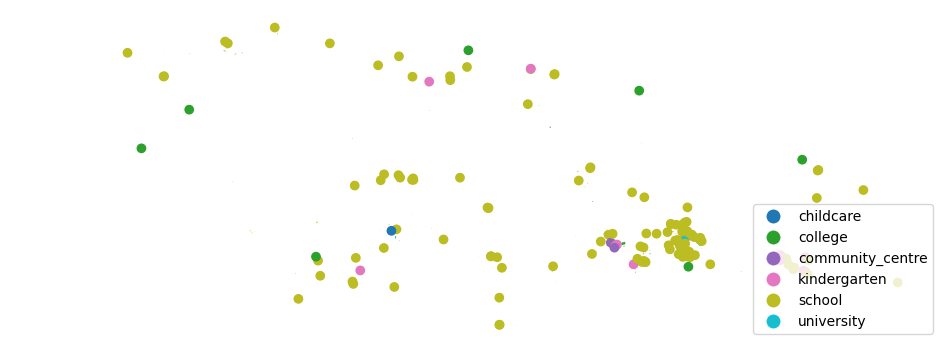

In [49]:
#import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1,figsize=(12,10))


asset_point.plot(column='asset',legend=True,ax=ax,legend_kwds={'loc': 'lower right'});


# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

In [61]:
# Merge DataFrames with indicator=True
merged_df = pd.merge(assets, asset_polys, how='outer', indicator=True)

# Select rows where the indicator is 'left_only' (only in df1)
missing_rows_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

missing_rows_df

# Save to GeoPackage
#assets.to_file('assets_education', driver='GPKG')
missing_rows_df.to_file('polys_assets_education', driver='GPKG')

,osm_id,name,geometry,asset
194,5492157,Success Primary,"MULTIPOLYGON (((-8660682.332 2098224.685, -866...",school
195,5492161,None,"MULTIPOLYGON (((-8660002.883 2095871.153, -865...",school
196,5492162,Spot Valley High School,"MULTIPOLYGON (((-8659961.438 2095778.455, -865...",school
197,5492168,None,"MULTIPOLYGON (((-8646002.887 2093166.974, -864...",school
198,5492169,None,"MULTIPOLYGON (((-8646098.121 2093197.021, -864...",school
...,...,...,...,...
973,None,St. Jago High School Main Building,"MULTIPOLYGON (((-8566315.230 2037556.247, -856...",school
987,None,None,"MULTIPOLYGON (((-8548009.130 2036086.570, -854...",school
989,None,None,"MULTIPOLYGON (((-8617670.819 2074587.496, -861...",school
990,None,None,"MULTIPOLYGON (((-8617673.546 2074612.215, -861...",school


In [11]:
import osm_flex
osm_flex.config.DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'main_road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food', 'buildings'])

In [201]:
help(ex.extract_cis)

Help on function extract_cis in module osm_flex.extract:

extract_cis(osm_path, ci_type)
    A wrapper around extract() to conveniently extract map info for a
    selection of  critical infrastructure types from the given osm.pbf file.
    No need to search for osm key/value tags and relevant geometry types.
    Parameters
    ----------
    osm_path : str or Path
        location of osm.pbf file from which to parse
    ci_type : str
        one of DICT_CIS_OSM.keys(), i.e. 'education', 'healthcare',
        'water', 'telecom', 'road', 'rail', 'air', 'gas', 'oil', 'power',
        'wastewater', 'food'
    See also
    -------
    DICT_CIS_OSM for the keys and key/value tags queried for the respective
    CIs. Modify if desired.



In [204]:
help(ex.DICT_CIS_OSM)

Help on dict object:

class dict(object)
 |  dict() -> new empty dictionary
 |  dict(mapping) -> new dictionary initialized from a mapping object's
 |      (key, value) pairs
 |  dict(iterable) -> new dictionary initialized as if via:
 |      d = {}
 |      for k, v in iterable:
 |          d[k] = v
 |  dict(**kwargs) -> new dictionary initialized with the name=value pairs
 |      in the keyword argument list.  For example:  dict(one=1, two=2)
 |  
 |  Built-in subclasses:
 |      StgDict
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, key, /)
 |      True if the dictionary has the specified key, else False.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>va

In [37]:
    if sub_system == 'road':
        assets = assets.loc[assets.geometry.geom_type == 'LineString']
        assets = assets.rename(columns={'highway' : 'asset'})
        list_of_highway_assets_to_keep =["living_street", "motorway", "motorway_link", "primary","primary_link",
                                         "residential","road", "secondary", "secondary_link","tertiary","tertiary_link", "trunk", "trunk_link","unclassified","service"]
        #reclassify assets 
        mapping_dict = {
            "living_street" : "tertiary", 
            "motorway" : "primary", 
            "motorway_link" : "primary", 
            "primary" : "primary", 
            "primary_link" : "primary", 
            "residential" : "tertiary",
            "road" : "secondary", 
            "secondary" : "secondary", 
            "secondary_link" : "secondary", 
            "tertiary" : "tertiary", 
            "tertiary_link" : "tertiary", 
            "trunk" : "primary",
            "trunk_link" : "primary",
            "unclassified" : "tertiary", 
            "service" : "tertiary"
        }
        assets['asset'] = assets.asset.apply(lambda x : mapping_dict[x])  #reclassification
    
    elif sub_system == 'rail':
        assets = assets.loc[assets.geometry.geom_type == 'LineString']
        assets = assets.rename(columns={'railway' : 'asset'})
    
    elif sub_system == 'air':
        assets = assets.rename(columns={'aeroway' : 'asset'})     
    
    elif sub_system == 'education':
        column_names_lst = ['amenity' , 'building']
        assets = filter_dataframe(assets, column_names_lst)

In [38]:
assets

,osm_id,amenity,asset,name,geometry
0,299737501,school,None,Chetwood School,POINT (-8674413.870 2093651.839)
1,442000525,school,None,Gordon Memorial Prep,POINT (-8551824.917 2040845.109)
2,671228563,school,None,St. Benedicts Primary,POINT (-8539961.476 2031920.895)
3,892577153,school,None,Holy Childhood Catholic Preparatory School,POINT (-8549077.708 2038610.680)
4,1185690079,school,None,Meadowbrook High Sch.,POINT (-8550920.658 2043124.423)
...,...,...,...,...,...
947,None,None,school,None,"MULTIPOLYGON (((-8548009.130 2036086.570, -854..."
948,None,school,None,None,"MULTIPOLYGON (((-8619274.298 2078185.301, -861..."
949,None,None,school,None,"MULTIPOLYGON (((-8617670.819 2074587.496, -861..."
950,None,None,school,None,"MULTIPOLYGON (((-8617673.546 2074612.215, -861..."
